# Regression to Predict the runs scored given the type of bowlers expected to bowl and the state of the match

Here, we will consider all the data available as we trying to get a relation between the strike rate, and deliveries per wicket vs each type of bowler vs the expeted runs scored 

Input --> Batter,  Team , Ball number, Innings, Non- striker  
Ouput --> Runs

In [7]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217242 entries, 0 to 217241
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   batter               217242 non-null  object 
 1   bowler               217242 non-null  object 
 2   non_striker          217242 non-null  object 
 3   runs_by_bat          217242 non-null  int64  
 4   extra_runs           217242 non-null  int64  
 5   total_runs_delivery  217242 non-null  int64  
 6   current_team_total   217242 non-null  int64  
 7   runs_remain          217242 non-null  float64
 8   batter_runs          217242 non-null  int64  
 9   balls_faced          217242 non-null  int64  
 10  wickets_fallen       217242 non-null  int64  
 11  extra_type           217242 non-null  object 
 12  delivery             217242 non-null  float64
 13  over                 217242 non-null  int64  
 14  wicket_type          217242 non-null  object 
 15  player_out       

In [3]:
data.iloc[:, 10:].head(20)

,wickets_fallen,extra_type,delivery,over,wicket_type,player_out,toss_decision,toss_winner,innings,venue,...,match_id,winning_team,batting_team,bowling_team,won,final_team_total,batter_type,non_striker_type,bowler_type,replacements
0,0,-,1.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
1,0,-,2.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
2,0,-,3.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
3,0,-,4.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
4,0,-,5.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
5,0,-,6.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
6,0,-,1.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
7,0,-,2.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
8,0,-,3.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement
9,0,-,4.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia_Sri Lanka_2017-02-17,Sri Lanka,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement


In [93]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'batter_type', 'non_striker_type']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)



	return player_scores




In [94]:
# selected_batters = ["PWH de Silva",'KIC Asalanka','BKG Mendis',"P Nissanka",'PHKD Mendis','S Samarawickrama','AD Mathews','MD Shanaka','DM de Silva','M Theekshana','PVD Chameera','N Thushara','M Pathirana','D Madushanka']

merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    merged_df = pd.concat([merged_df, player_scores])

merged_df.to_csv('merged_df_checkpoint.csv')

Analyzing Player AJ Finch
Analyzing Player M Klinger


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TM Head
Analyzing Player MC Henriques
Analyzing Player AJ Turner
Analyzing Player JP Faulkner


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player N Dickwella
Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera
Analyzing Player S Prasanna
Analyzing Player BR Dunk


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TD Paine
Analyzing Player PJ Cummins
Analyzing Player AJ Tye
Analyzing Player JA Richardson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BKG Mendis
Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MD Shanaka
Analyzing Player JRMVB Sanjaya
Analyzing Player KL Rahul


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AT Rayudu
Analyzing Player Mandeep Singh
Analyzing Player MK Pandey
Analyzing Player KM Jadhav


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MS Dhoni
Analyzing Player AR Patel
Analyzing Player R Dhawan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CJ Chibhabha
Analyzing Player H Masakadza
Analyzing Player R Mutumbami


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Sikandar Raza
Analyzing Player MN Waller
Analyzing Player CT Mutombodzi


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player E Chigumbura
Analyzing Player AG Cremer
Analyzing Player N Madziva
Analyzing Player PJ Moor


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DT Tiripano
Analyzing Player T Muzarabani
Analyzing Player DS Kulkarni
Analyzing Player V Sibanda
Analyzing Player T Maruma


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Tamim Iqbal
Analyzing Player Imrul Kayes
Analyzing Player Sabbir Rahman


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Shakib Al Hasan
Analyzing Player Soumya Sarkar


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mahmudullah
Analyzing Player Mosaddek Hossain


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mashrafe Mortaza
Analyzing Player Nurul Hasan
Analyzing Player Rubel Hossain
Analyzing Player NT Broom


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KS Williamson
Analyzing Player C Munro


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CJ Anderson
Analyzing Player TC Bruce
Analyzing Player C de Grandhomme
Analyzing Player Mustafizur Rahman


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player L Ronchi
Analyzing Player JDS Neesham
Analyzing Player MJ Santner


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GD Phillips
Analyzing Player BM Wheeler
Analyzing Player TG Southee


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TA Boult
Analyzing Player HM Amla
Analyzing Player Q de Kock


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player F du Plessis
Analyzing Player AB de Villiers


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JP Duminy
Analyzing Player F Behardien
Analyzing Player CH Morris


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player WD Parnell
Analyzing Player JJ Roy
Analyzing Player AD Hales


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JM Bairstow
Analyzing Player JT Smuts
Analyzing Player RR Hendricks


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DA Miller
Analyzing Player SW Billings


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LS Livingstone
Analyzing Player JC Buttler


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player EJG Morgan
Analyzing Player LA Dawson
Analyzing Player M Mosehle


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AL Phehlukwayo
Analyzing Player M Morkel
Analyzing Player D Paterson
Analyzing Player DJ Malan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player LE Plunkett
Analyzing Player DJ Willey
Analyzing Player TK Curran
Analyzing Player JE Root


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AU Rashid
Analyzing Player CJ Jordan
Analyzing Player CH Gayle


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player E Lewis
Analyzing Player MN Samuels
Analyzing Player CAK Walton


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KA Pollard
Analyzing Player R Powell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CR Brathwaite
Analyzing Player SP Narine
Analyzing Player AR Nurse
Analyzing Player JE Taylor


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KOK Williams
Analyzing Player BA Stokes
Analyzing Player V Kohli


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SK Raina
Analyzing Player Yuvraj Singh
Analyzing Player HH Pandya


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Parvez Rasool
Analyzing Player MM Ali
Analyzing Player TS Mills
Analyzing Player RR Pant


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RG Sharma


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AM Rahane
Analyzing Player J Charles
Analyzing Player AD Russell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJ Bravo
Analyzing Player LMP Simmons


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player ADS Fletcher
Analyzing Player S Badree
Analyzing Player Sharjeel Khan
Analyzing Player Khalid Latif


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Babar Azam
Analyzing Player N Pooran


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shoaib Malik
Analyzing Player Sarfraz Ahmed


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Umar Akmal
Analyzing Player DA Warner


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJM Short
Analyzing Player CA Lynn
Analyzing Player GJ Maxwell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MJ Guptill
Analyzing Player LRPL Taylor


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TA Blundell
Analyzing Player IS Sodhi
Analyzing Player MP Stoinis


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AT Carey
Analyzing Player MA Wood
Analyzing Player JM Vince
Analyzing Player MS Chapman


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TL Seifert
Analyzing Player AC Agar
Analyzing Player Mushfiqur Rahim


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mohammad Saifuddin
Analyzing Player Mehedi Hasan Miraz
Analyzing Player Taskin Ahmed
Analyzing Player Shafiul Islam


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Liton Das
Analyzing Player Kamran Akmal


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Ahmed Shehzad
Analyzing Player Mohammad Hafeez


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JO Holder
Analyzing Player Fakhar Zaman
Analyzing Player Imad Wasim


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Sohail Tanvir
Analyzing Player Shadab Khan
Analyzing Player Wahab Riaz


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Hasan Ali
Analyzing Player MDKJ Perera
Analyzing Player NLTC Perera


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JN Mohammed
Analyzing Player S Dhawan
Analyzing Player KD Karthik


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RA Jadeja
Analyzing Player R Ashwin
Analyzing Player AD Mathews


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SMA Priyanjan
Analyzing Player I Udana
Analyzing Player AK Kitchen
Analyzing Player DAJ Bracewell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SD Hope
Analyzing Player SO Hetmyer
Analyzing Player RR Emrit
Analyzing Player Umar Amin


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mohammad Nawaz (3)
Analyzing Player Haris Sohail
Analyzing Player Faheem Ashraf
Analyzing Player Mohammad Amir


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SHA Rance
Analyzing Player Aamer Yamin
Analyzing Player DT Christian
Analyzing Player NM Coulter-Nile
Analyzing Player A Zampa


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player B Kumar
Analyzing Player Kuldeep Yadav
Analyzing Player JJ Bumrah
Analyzing Player YS Chahal
Analyzing Player KW Richardson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MJ Swepson
Analyzing Player B Stanlake
Analyzing Player TWM Latham
Analyzing Player HM Nicholls
Analyzing Player SS Iyer


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MD Gunathilaka
Analyzing Player S Samarawickrama
Analyzing Player ML Udawatte
Analyzing Player SS Pathirana


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PC de Silva
Analyzing Player H Klaasen
Analyzing Player CJ Dala
Analyzing Player T Shamsi


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player C Jonker
Analyzing Player A Dananjaya
Analyzing Player PVD Chameera
Analyzing Player MVT Fernando


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player N Pradeep
Analyzing Player Zakir Hasan
Analyzing Player Afif Hossain
Analyzing Player Ariful Haque


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mohammad Mithun
Analyzing Player Mahedi Hasan
Analyzing Player Abu Jayed
Analyzing Player Nazmul Islam


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player LD Chandimal
Analyzing Player BMAJ Mendis
Analyzing Player RAS Lakmal


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player V Shankar
Analyzing Player Mohammad Shahzad
Analyzing Player Karim Sadiq
Analyzing Player Asghar Stanikzai
Analyzing Player Mohammad Nabi


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Sharafuddin Ashraf
Analyzing Player Najibullah Zadran
Analyzing Player Shafiqullah
Analyzing Player SF Mire


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BRM Taylor
Analyzing Player RP Burl
Analyzing Player KM Jarvis


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TL Chatara
Analyzing Player B Muzarabani
Analyzing Player Gulbadin Naib
Analyzing Player Rashid Khan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Aftab Alam
Analyzing Player Hussain Talat
Analyzing Player Asif Ali
Analyzing Player D Ramdin


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KMA Paul
Analyzing Player OF Smith
Analyzing Player AM McCarthy
Analyzing Player JL Denly


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DM de Silva
Analyzing Player PHKD Mendis
Analyzing Player MA Aponso
Analyzing Player PADLR Sandakan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PR Stirling
Analyzing Player JNK Shannon
Analyzing Player A Balbirnie


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Simi Singh
Analyzing Player GC Wilson
Analyzing Player KJ O'Brien
Analyzing Player SW Poynter


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SR Thompson
Analyzing Player GH Dockrell
Analyzing Player WB Rankin
Analyzing Player PKD Chase


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player WTS Porterfield
Analyzing Player K Rabada
Analyzing Player L Ngidi
Analyzing Player TK Musakanda


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player TS Chisoro
Analyzing Player J Nyumbu
Analyzing Player CB Mpofu
Analyzing Player C Zhuwao
Analyzing Player NJ Maddinson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player B Mavuta
Analyzing Player WP Masakadza
Analyzing Player JD Wildermuth
Analyzing Player Sahibzada Farhan
Analyzing Player GL Cloete


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HE van der Dussen
Analyzing Player SC Williams
Analyzing Player Mohammad Rizwan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JN Malan
Analyzing Player Shaheen Shah Afridi
Analyzing Player BE Hendricks
Analyzing Player L Sipamla
Analyzing Player DW Steyn


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Imran Tahir
Analyzing Player WIA Fernando
Analyzing Player AK Perera
Analyzing Player AK Markram


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player D Pretorius
Analyzing Player BR McDermott
Analyzing Player KH Pandya
Analyzing Player Usman Ghani


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Samiullah Shenwari
Analyzing Player Karim Janat
Analyzing Player Abul Hasan
Analyzing Player Abu Hider
Analyzing Player Hazratullah


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player J Little
Analyzing Player TE Kane
Analyzing Player BM Duckett
Analyzing Player Imam-ul-Haq
Analyzing Player DM Bravo


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player FA Allen
Analyzing Player SS Cottrell
Analyzing Player O Thomas
Analyzing Player SE Rutherford


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KK Ahmed
Analyzing Player DJ Mitchell
Analyzing Player SC Kuggeleijn
Analyzing Player CAK Rajitha


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CBRLS Kumara
Analyzing Player MR Marsh
Analyzing Player NM Lyon
Analyzing Player LH Ferguson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player K Pierre
Analyzing Player D Bishoo
Analyzing Player OC McCoy
Analyzing Player JD Campbell
Analyzing Player SC Getkate


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player L Tucker
Analyzing Player Najeeb Tarakai
Analyzing Player PSP Handscomb
Analyzing Player UT Yadav


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CR Ervine
Analyzing Player GJ Thompson
Analyzing Player MR Adair
Analyzing Player GJ Delany


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PBB Rajapaksa
Analyzing Player BOP Fernando
Analyzing Player PWH de Silva


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SPD Smith
Analyzing Player GSNFG Jayasuriya
Analyzing Player Iftikhar Ahmed


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Khushdil Shah
Analyzing Player Mohammad Hasnain
Analyzing Player T Bavuma
Analyzing Player BC Fortuin


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MS Wade
Analyzing Player MA Starc
Analyzing Player PJ van Biljon


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player A Nortje
Analyzing Player Washington Sundar
Analyzing Player Navdeep Saini
Analyzing Player Mohammad Naim


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player S Dube
Analyzing Player Aminul Islam
Analyzing Player BA King
Analyzing Player DL Chahar


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HR Walsh
Analyzing Player SM Curran
Analyzing Player L Gregory
Analyzing Player S Mahmood


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PR Brown
Analyzing Player T Banton
Analyzing Player BM Tickner
Analyzing Player SV Samson
Analyzing Player SN Thakur


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HK Bennett
Analyzing Player HD Rutherford
Analyzing Player TD Astle
Analyzing Player LD Madushanka
Analyzing Player Rahmanullah Gurbaz


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Ibrahim Zadran
Analyzing Player Fareed Ahmad
Analyzing Player Naveen-ul-Haq
Analyzing Player Mujeeb Ur Rahman


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RW Chakabva
Analyzing Player Taijul Islam
Analyzing Player Nazmul Hossain Shanto
Analyzing Player A Ndlovu


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Fazal Niazai
Analyzing Player Haider Ali
Analyzing Player M Bhanuka
Analyzing Player HT Tector


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BJ McCarthy
Analyzing Player CA Young
Analyzing Player Ahsan Ali
Analyzing Player TS Kamunhukamwe


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player W Madhevere
Analyzing Player CT Mumba
Analyzing Player SA Abbott
Analyzing Player DR Sams


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Abdullah Shafique
Analyzing Player M Shumba
Analyzing Player M Faraz Akram
Analyzing Player DP Conway


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KR Mayers
Analyzing Player Haris Rauf
Analyzing Player JR Philippe
Analyzing Player KA Jamieson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Shoriful Islam
Analyzing Player Nasum Ahmed
Analyzing Player FH Allen
Analyzing Player WA Young


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GF Linde
Analyzing Player MW Parkinson
Analyzing Player Sohaib Maqsood
Analyzing Player Azam Khan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GJ Snyman
Analyzing Player Usman Qadir
Analyzing Player Ishan Kishan
Analyzing Player JC Archer


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SA Yadav
Analyzing Player B Fernando
Analyzing Player WJ Lubbe
Analyzing Player SSB Magala


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PWA Mulder
Analyzing Player LB Williams
Analyzing Player B White
Analyzing Player P Nissanka


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KNA Bandara
Analyzing Player K Sinclair
Analyzing Player FH Edwards
Analyzing Player R Shepherd
Analyzing Player AJ Hosein


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HC Brook
Analyzing Player PD Salt
Analyzing Player GHS Garton
Analyzing Player RJW Topley


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Danish Aziz
Analyzing Player T Marumani
Analyzing Player LM Jongwe
Analyzing Player Arshad Iqbal


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player R Ngarava
Analyzing Player PP Shaw
Analyzing Player KIC Asalanka
Analyzing Player C Karunaratne


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RD Gaikwad
Analyzing Player D Padikkal
Analyzing Player N Rana
Analyzing Player RTM Mendis
Analyzing Player RD Chahar


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CV Varun
Analyzing Player C Sakariya
Analyzing Player JR Hazlewood
Analyzing Player JP Behrendorff
Analyzing Player Mohammad Wasim


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JP Inglis
Analyzing Player M Theekshana
Analyzing Player JDF Vandersay
Analyzing Player K Mishara


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player J Liyanage
Analyzing Player D Myers
Analyzing Player Shamim Hossain
Analyzing Player NT Ellis
Analyzing Player P Jayawickrama


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player R Ravindra
Analyzing Player CE McConchie
Analyzing Player AY Patel
Analyzing Player JA Duffy
Analyzing Player C Campher


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player NA Rock
Analyzing Player W McClintock
Analyzing Player AR McBrine
Analyzing Player KA Maharaj
Analyzing Player R Rampaul


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RL Chase
Analyzing Player CR Woakes
Analyzing Player DJ Hooda
Analyzing Player HV Patel


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Arshdeep Singh
Analyzing Player RJ Gleeson
Analyzing Player Avesh Khan
Analyzing Player Ravi Bishnoi
Analyzing Player RR Rossouw


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player T Stubbs
Analyzing Player Saif Hassan
Analyzing Player Mohammad Nawaz
Analyzing Player VR Iyer


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AF Milne
Analyzing Player DC Drakes
Analyzing Player M Jansen
Analyzing Player DC Thomas
Analyzing Player SSJ Brooks


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player M Labuschagne
Analyzing Player C Green
Analyzing Player BJ Dwarshuis
Analyzing Player T Munyonga
Analyzing Player TH David


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Azmatullah Omarzai
Analyzing Player Fazalhaq Farooqi
Analyzing Player Shan Masood
Analyzing Player F Hand


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Hasan Mahmud
Analyzing Player B Evans
Analyzing Player Yasir Ali Chowdhury
Analyzing Player Mohammed Shami
Analyzing Player Mohammad Haris


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Naseem Shah
Analyzing Player Darwish Rasooli
Analyzing Player Qais Ahmad
Analyzing Player Munim Shahriar
Analyzing Player D Cleaver


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MG Bracewell
Analyzing Player Hashmatullah Shahidi
Analyzing Player GI Hume
Analyzing Player N Thushara
Analyzing Player I Kaia


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Ihsanullah
Analyzing Player Afsar Zazai
Analyzing Player Noor Ahmad
Analyzing Player Nijat Masood
Analyzing Player C Madande


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Anamul Haque
Analyzing Player RA Reifer
Analyzing Player AS Joseph
Analyzing Player Y Cariah
Analyzing Player CJ Bowes


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HB Shipley
Analyzing Player PM Liyanagamage
Analyzing Player D Madushanka
Analyzing Player Parvez Hossain Emon
Analyzing Player VM Nyauchi
Analyzing Player WG Jacks


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player OP Stone
Analyzing Player Aamer Jamal
Analyzing Player M Pathirana
Analyzing Player Shahnawaz Dhani
Analyzing Player AM Fernando
Analyzing Player Mohammed Siraj


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player L Wood
Analyzing Player AAP Atkinson
Analyzing Player Rehan Ahmed
Analyzing Player BA Carse
Analyzing Player MJ Henry


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BG Lister
Analyzing Player Saim Ayub
Analyzing Player Zaman Khan
Analyzing Player GR Adair
Analyzing Player ST Doheny


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GS Ballance
Analyzing Player Shubman Gill
Analyzing Player RA Tripathi
Analyzing Player Shivam Mavi
Analyzing Player Umran Malik


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Rony Talukdar
Analyzing Player Towhid Hridoy
Analyzing Player Rishad Hossain
Analyzing Player Tayyab Tahir
Analyzing Player Sediqullah Atal


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MW Short
Analyzing Player AM Hardie
Analyzing Player D Brevis
Analyzing Player G Coetzee
Analyzing Player MP Breetzke


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player D Ferreira
Analyzing Player MW Forde
Analyzing Player G Motie
Analyzing Player Tilak Varma
Analyzing Player Mukesh Kumar


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player YBK Jaiswal
Analyzing Player RK Singh
Analyzing Player JM Sharma
Analyzing Player N Burger
Analyzing Player BV Sears


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Tanvir Islam
Analyzing Player Usama Mir
Analyzing Player Abbas Afridi
Analyzing Player Haseebullah Khan
Analyzing Player JA Clarkson
Analyzing Player T Sangha


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CJ Green
Analyzing Player Rahmat Shah
Analyzing Player Noor Ali Zadran
Analyzing Player Shahidullah
Analyzing Player Zahir Khan
Analyzing Player S Daniel


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player L Croospulle
Analyzing Player MNK Fernando
Analyzing Player SSD Arachchige
Analyzing Player LU Igalagamage
Analyzing Player RS Fernando
Analyzing Player SMLD Samarakoon


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player V Viyaskanth
Analyzing Player N Vimukthi
Analyzing Player Mahmudul Hasan Joy
Analyzing Player Shahadat Hossain
Analyzing Player Jaker Ali
Analyzing Player Mrittunjoy Chowdhury


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Rakibul Hasan
Analyzing Player R Mondol
Analyzing Player Omair Yousuf
Analyzing Player Mirza Baig
Analyzing Player Rohail Nazir
Analyzing Player Qasim Akram


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Arafat Minhas
Analyzing Player Sufiyan Muqeem
Analyzing Player Zubaid Akbari
Analyzing Player BJ Bennett
Analyzing Player T Gwandu


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mohammad Ishaq
Analyzing Player Ijaz Ahmad Ahmadzai
Analyzing Player Nangeyalia Kharote
Analyzing Player AC Gilchrist
Analyzing Player ML Hayden


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player A Symonds
Analyzing Player MJ Clarke
Analyzing Player MEK Hussey
Analyzing Player RT Ponting


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DR Martyn
Analyzing Player B Lee
Analyzing Player JN Gillespie
Analyzing Player MS Kasprowicz
Analyzing Player GD McGrath


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player ME Trescothick
Analyzing Player GO Jones
Analyzing Player A Flintoff
Analyzing Player KP Pietersen


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MP Vaughan
Analyzing Player PD Collingwood
Analyzing Player AJ Strauss
Analyzing Player VS Solanki
Analyzing Player SM Katich


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BB McCullum
Analyzing Player SP Fleming
Analyzing Player MS Sinclair
Analyzing Player SB Styris


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CD McMillan
Analyzing Player CL Cairns
Analyzing Player HJH Marshall
Analyzing Player AR Adams
Analyzing Player JW Wilson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DR Tuffey
Analyzing Player KD Mills
Analyzing Player NJ Astle
Analyzing Player JDP Oram


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GC Smith
Analyzing Player JH Kallis
Analyzing Player HH Gibbs
Analyzing Player JM Kemp


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MV Boucher
Analyzing Player SM Pollock
Analyzing Player AG Prince
Analyzing Player JA Morkel


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player CK Langeveldt
Analyzing Player M Ntini
Analyzing Player A Nel
Analyzing Player IR Bell
Analyzing Player JWM Dalrymple


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MH Yardy
Analyzing Player CMW Read
Analyzing Player SI Mahmood
Analyzing Player Younis Khan
Analyzing Player Shahid Afridi


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Mohammad Yousuf
Analyzing Player Inzamam-ul-Haq
Analyzing Player Abdul Razzaq
Analyzing Player TT Bresnan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player ST Jayasuriya
Analyzing Player DPMD Jayawardene
Analyzing Player TM Dilshan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player KC Sangakkara
Analyzing Player RP Arnold
Analyzing Player MF Maharoof
Analyzing Player CRD Fernando


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JR Hopes
Analyzing Player HH Dippenaar
Analyzing Player AJ Hall
Analyzing Player JA Rudolph
Analyzing Player J Botha


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GJP Kruger
Analyzing Player M Zondeki
Analyzing Player L Vincent
Analyzing Player PG Fulton
Analyzing Player JEC Franklin


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SE Bond
Analyzing Player D Ganga
Analyzing Player RS Morton
Analyzing Player DR Smith


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player WW Hinds
Analyzing Player S Chanderpaul
Analyzing Player SR Watson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GB Hogg
Analyzing Player NW Bracken
Analyzing Player LE Bosman
Analyzing Player JJ van der Wath
Analyzing Player CL White


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player EC Joyce
Analyzing Player PA Nixon
Analyzing Player J Lewis
Analyzing Player MS Panesar
Analyzing Player JM Anderson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JAH Marshall
Analyzing Player PD McGlashan
Analyzing Player MR Gillespie
Analyzing Player MS Atapattu
Analyzing Player LPC Silva


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HMCM Bandara
Analyzing Player V Sehwag
Analyzing Player SR Tendulkar
Analyzing Player D Mongia
Analyzing Player RJ Peterson


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player R Telemachus
Analyzing Player T Henderson
Analyzing Player AN Cook
Analyzing Player MJ Prior
Analyzing Player IJL Trott


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player OA Shah
Analyzing Player AD Mascarenhas
Analyzing Player SCJ Broad
Analyzing Player DS Smith


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DJG Sammy
Analyzing Player ACL Richards
Analyzing Player RR Sarwan
Analyzing Player BJ Hodge


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player BJ Haddin
Analyzing Player MG Johnson
Analyzing Player T Taibu
Analyzing Player S Matsikenyeri


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Nazimuddin
Analyzing Player Aftab Ahmed
Analyzing Player Mohammad Ashraful
Analyzing Player Alok Kapali


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player DBL Powell
Analyzing Player DL Maddy
Analyzing Player LJ Wright
Analyzing Player CP Schofield


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player P Utseya
Analyzing Player RJ Kirtley
Analyzing Player G Gambhir
Analyzing Player RV Uthappa


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player IK Pathan
Analyzing Player Harbhajan Singh
Analyzing Player AB Agarkar
Analyzing Player S Sreesanth
Analyzing Player Salman Butt


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Imran Nazir
Analyzing Player Misbah-ul-Haq
Analyzing Player Yasir Arafat
Analyzing Player DL Vettori


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Farhad Reza
Analyzing Player Abdur Razzak
Analyzing Player Syed Rasel
Analyzing Player RP Singh
Analyzing Player JS Patel


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JN Snape
Analyzing Player VD Philander
Analyzing Player J Mubarak
Analyzing Player G Wijekoon
Analyzing Player WPUJC Vaas


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Nadif Chowdhury
Analyzing Player NL McCullum
Analyzing Player Junaid Siddique
Analyzing Player YK Pathan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Umar Gul
Analyzing Player Mohammad Asif
Analyzing Player AC Voges
Analyzing Player LA Pomersbach
Analyzing Player JM How


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player P Kumar
Analyzing Player I Sharma
Analyzing Player DR Flynn
Analyzing Player MJ Mason
Analyzing Player GJ Hopkins


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JL Ontong
Analyzing Player RN Lewis
Analyzing Player P Mustard
Analyzing Player GP Swann
Analyzing Player RJ Sidebottom


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JD Ryder
Analyzing Player CS Martin
Analyzing Player PA Hitchcock
Analyzing Player Shoaib Akhtar
Analyzing Player MN van Wyk


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GH Bodi
Analyzing Player BA Parchment
Analyzing Player SE Marsh
Analyzing Player DJ Hussey


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player XM Marshall
Analyzing Player WKD Perkins
Analyzing Player Dhiman Ghosh
Analyzing Player Fawad Alam
Analyzing Player RS Bopara


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Raqibul Hasan
Analyzing Player Naeem Islam
Analyzing Player Mehrab Hossain jnr
Analyzing Player RK Kleinveldt
Analyzing Player J Louw


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player VB van Jaarsveld
Analyzing Player CJ Ferguson
Analyzing Player RE van der Merwe
Analyzing Player BW Hilfenhaus
Analyzing Player SW Tait


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player LL Tsotsobe
Analyzing Player ND McKenzie
Analyzing Player PM Siddle
Analyzing Player GD Elliott
Analyzing Player SM Davies


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GJ Batty
Analyzing Player A Khan
Analyzing Player JS Foster
Analyzing Player JP Bray
Analyzing Player NJ O'Brien


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JF Mooney
Analyzing Player NM Hauritz
Analyzing Player AC Botha
Analyzing Player AR White
Analyzing Player RM West


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player AR Cusack
Analyzing Player WK McCallan
Analyzing Player DT Johnston
Analyzing Player PC Connell
Analyzing Player AJ Redmond


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SJ Benn
Analyzing Player IG Butler
Analyzing Player Shahzaib Hasan
Analyzing Player M Muralitharan
Analyzing Player BAW Mendis


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Z Khan
Analyzing Player Shoaib Khan jnr
Analyzing Player SHT Kandamby
Analyzing Player K Weeraratne
Analyzing Player T Thushara


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SE Findlay
Analyzing Player CS Baugh
Analyzing Player EP Thompson
Analyzing Player HG Kuhn
Analyzing Player R McLaren


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MJ North
Analyzing Player Nazmul Hossain
Analyzing Player DM Richards
Analyzing Player TM Dowlin
Analyzing Player FL Reifer
Analyzing Player DE Bernard


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player RJMGM Rupasinghe
Analyzing Player TR Birt
Analyzing Player N Deonarine
Analyzing Player NO Miller
Analyzing Player DP Nannes


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Imran Farhat
Analyzing Player Naved-ul-Hasan
Analyzing Player Saeed Ajmal
Analyzing Player Suhrawadi Shuvo
Analyzing Player MJ Lumb


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player C Kieswetter
Analyzing Player M Vijay
Analyzing Player Mohammad Sami
Analyzing Player AM Blignaut
Analyzing Player CK Coventry


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GA Lamb
Analyzing Player RW Price
Analyzing Player RJ Harris
Analyzing Player Jahurul Islam
Analyzing Player A Nehra


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Abdur Rehman
Analyzing Player S Randiv
Analyzing Player UWMBCA Welegedara
Analyzing Player CU Jayasinghe
Analyzing Player PJ Ingram


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SNJ O'Keefe
Analyzing Player BJ Watling
Analyzing Player AB Dinda
Analyzing Player PP Ojha
Analyzing Player AB Barath


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player SW Masakadza
Analyzing Player AN Petersen
Analyzing Player KAJ Roach
Analyzing Player JW Hastings
Analyzing Player CJ McKay


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player A Shahzad
Analyzing Player NV Ojha
Analyzing Player EC Rainsford
Analyzing Player RJ Nicol
Analyzing Player AJ McKay


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Zulqarnain Haider
Analyzing Player CA Ingram
Analyzing Player KM Dabengwa
Analyzing Player J Theron
Analyzing Player DG Brownlie


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Asad Shafiq
Analyzing Player SR Patel
Analyzing Player PA Patel
Analyzing Player R Dravid
Analyzing Player R Vinay Kumar


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MM Patel
Analyzing Player Mohammad Salman
Analyzing Player Junaid Khan
Analyzing Player DP Hyatt
Analyzing Player CD Barnwell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player S Badrinath
Analyzing Player JL Pattinson
Analyzing Player MDK Perera
Analyzing Player HMRKB Herath
Analyzing Player GJ Bailey


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player XJ Doherty
Analyzing Player F Mutizwa
Analyzing Player KO Meth
Analyzing Player AM Ellis
Analyzing Player RE Levi


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player MK Tiwary
Analyzing Player Rameez Raja (2)
Analyzing Player Yasir Shah
Analyzing Player NE Bonner
Analyzing Player DO Christian
Analyzing Player SG Borthwick


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player JW Dernbach
Analyzing Player MC Bascombe
Analyzing Player Awais Zia
Analyzing Player Hammad Azam
Analyzing Player Aizaz Cheema


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Nasir Hossain
Analyzing Player BV Vitori
Analyzing Player NG Jones
Analyzing Player Ziaur Rahman
Analyzing Player Elias Sunny


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player HDRL Thirimanne
Analyzing Player Nasir Jamshed
Analyzing Player ST Finn
Analyzing Player GE Mathurin


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Shakeel Ansar
Analyzing Player KS Lokuarachchi
Analyzing Player SMSM Senanayake
Analyzing Player RMS Eranga
Analyzing Player JC Tredwell


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PP Chawla
Analyzing Player Fawad Ahmed
Analyzing Player MC Sorensen
Analyzing Player RM Hira
Analyzing Player MJ McClenaghan


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player H Davids
Analyzing Player KJ Abbott
Analyzing Player Raza Hasan
Analyzing Player BJ Rohrer
Analyzing Player BCJ Cutting


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player N M'shangwe
Analyzing Player Shamsur Rahman
Analyzing Player Sohag Gazi
Analyzing Player Mominul Haque
Analyzing Player T Panyangara


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player D Wiese
Analyzing Player Zulfiqar Babar
Analyzing Player TL Best
Analyzing Player Mohammad Irfan
Analyzing Player Bilawal Bhatti


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Usman Shinwari
Analyzing Player Anwar Ali
Analyzing Player KOA Powell
Analyzing Player MA Carberry
Analyzing Player KDK Vithanage


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Al-Amin Hossain
Analyzing Player AP Devcich
Analyzing Player AD Poynter
Analyzing Player JM Muirhead
Analyzing Player DE Bollinger


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Arafat Sunny
Analyzing Player TJ Murtagh
Analyzing Player PJ Hughes
Analyzing Player Saad Nasim
Analyzing Player NJ Reardon
Analyzing Player CJ Boyce


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player GH Worker
Analyzing Player AM Phangiso
Analyzing Player Mukhtar Ahmed
Analyzing Player Nauman Anwar
Analyzing Player UT Khawaja


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player PM Nevill
Analyzing Player STR Binny
Analyzing Player MM Sharma
Analyzing Player Sandeep Sharma
Analyzing Player Rafatullah Mohmand


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Imran Khan (1)
Analyzing Player RLB Rambukwella
Analyzing Player KMC Bandara
Analyzing Player TB de Bruyn
Analyzing Player ST de Silva
Analyzing Player Shuvagata Hom


/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
/tmp/ipykernel_1282148/868147661.py:90: DeprecationWarning: DataFrameGroupBy.apply operated 

Analyzing Player Muktar Ali
Analyzing Player Khurram Manzoor


In [95]:
import pandas as pd
import numpy as np

merged_df = pd.read_csv('merged_df_checkpoint.csv')
merged_df.reset_index(inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14957 entries, 0 to 14956
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                14957 non-null  int64  
 1   Unnamed: 0           14957 non-null  int64  
 2   match_id             14957 non-null  object 
 3   batter               14957 non-null  object 
 4   batter_runs          14957 non-null  int64  
 5   balls_faced          14957 non-null  int64  
 6   wicket_type          14957 non-null  object 
 7   won                  14957 non-null  float64
 8   innings              14957 non-null  int64  
 9   wickets_fallen       14957 non-null  int64  
 10  bowling_team         14957 non-null  object 
 11  batting_team         14957 non-null  object 
 12  venue                14957 non-null  object 
 13  toss_winner          14957 non-null  int64  
 14  batter_type          14957 non-null  object 
 15  non_striker_type     14957 non-null 

In [96]:
merged_df.drop(['index','Unnamed: 0'], axis = 1, inplace = True)
merged_df.head()

,match_id,batter,batter_runs,balls_faced,wicket_type,won,innings,wickets_fallen,bowling_team,batting_team,...,current_team_total,strike_rate,out,last_ball,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,Right arm Fast,Right arm Legbreak,Right arm Offbreak
0,Australia_England_2011-01-12,AJ Finch,15,14,0,0.0,1,3,England,Australia,...,116,107.14,False,120,0.0,6.0,0.0,49.0,0.0,6.0
1,Australia_England_2011-01-14,AJ Finch,53,33,0,1.0,1,4,England,Australia,...,76,160.61,False,120,12.0,18.0,0.0,55.0,0.0,32.0
2,Australia_England_2014-01-29,AJ Finch,52,31,caught,1.0,1,0,England,Australia,...,3,167.74,True,64,0.0,27.0,0.0,180.0,25.0,17.0
3,Australia_England_2014-01-31,AJ Finch,10,11,lbw,1.0,2,0,England,Australia,...,0,90.91,True,31,24.0,0.0,0.0,101.0,38.0,29.0
4,Australia_England_2014-02-02,AJ Finch,30,21,caught,1.0,1,0,England,Australia,...,0,142.86,True,40,12.0,0.0,0.0,170.0,12.0,30.0


Split train and test data set (By Stratifying according to runs scored)

<Axes: >

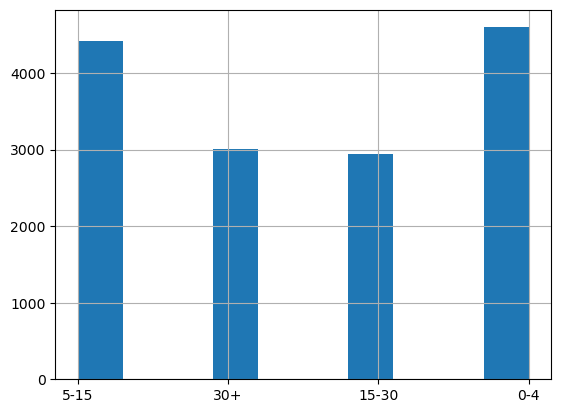

In [97]:
merged_df['batter_runs_cat'] = pd.cut(merged_df['batter_runs'], bins = [-1, 4, 15, 30, np.inf], labels = ['0-4', '5-15', '15-30', '30+'])
merged_df['batter_runs_cat'].hist()

In [98]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split Train Test Data Sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42);
for train_index, test_index in split.split(merged_df, merged_df['batter_runs_cat']):
    strat_train_set = merged_df.loc[train_index]
    strat_test_set = merged_df.loc[test_index]

print(strat_test_set['batter_runs_cat'].value_counts() / len(strat_test_set));

# Drop the categorical column used for strat
for set_ in (strat_test_set, strat_train_set):
    set_.drop('batter_runs_cat', axis = 1, inplace = True)


strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

batter_runs_cat
0-4      0.307487
5-15     0.294786
30+      0.200869
15-30    0.196858
Name: count, dtype: float64


## Attach the bowler type data to the dataset

In [99]:
def get_player_v_bowlers(player_name: str, match_ids, innings=[1, 2], ) -> pd.DataFrame:
    player_data = data.loc[
        (data['batter'] == player_name) & (data['innings'].isin(
            innings)) & (data['match_id'].isin(match_ids))
    ]

    player_data.head()

    # Convert all medium bowlers to fast
    player_data.loc[player_data['bowler_type'] ==
                    'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
    player_data.loc[player_data['bowler_type'] ==
                    'Right arm Medium', 'bowler_type'] = 'Right arm Fast'

    player_data['out'] = (player_data['wicket_type'] != '0') & (
        player_data['wicket_type'] != 'run out')

    cols = ['batter', 'non_striker', 'runs_by_bat', 'out',
            'won', 'innings', 'over', 'delivery', 'bowler_type']
    player_data = player_data[cols]

    gp = player_data.groupby('bowler_type')

    player_v_bowler = pd.DataFrame()
    player_v_bowler['strike_rate'] = round(gp['runs_by_bat'].mean() * 100, 3)
    player_v_bowler['strike_rate_std'] = gp['runs_by_bat'].std()
    player_v_bowler['wickets'] = gp['out'].sum()
    player_v_bowler['deliveries_per_wicket'] = round(1 / gp['out'].mean(), 3)
    player_v_bowler['deliveries'] = gp.size()
    return player_v_bowler


# for player in data['batter'].unique():

#     # Attaching the player_v_bowler results to this dataset
#     print(f"Updating {player}...")
#     print(strat_train_set[strat_train_set['batter' == player]]);
#     player_scores = strat_train_set[strat_train_set['batter' == player]]

#     player_vs_bowler = get_player_v_bowlers(player_name, player_scores.index)

#     bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
#                     'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
#     for bowler_type in bowler_types:
#         if bowler_type in player_vs_bowler.index:
#             player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
#                                                                                  'strike_rate'] / 100 * player_scores[bowler_type]
#             player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
#                 player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
#             player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
#                                                                                      'deliveries_per_wicket']
#         else:
#             player_scores[bowler_type] = 0
#             player_scores[f'{bowler_type} Expected Runs'] = 0
#             player_scores[f'{bowler_type} Expected Wickets'] = 0
#             player_scores[f'{bowler_type} Strike Rate'] = 0
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0

#     # strat_train_set.update(player_scores)

match_ids_in_train_set = strat_train_set['match_id']
def attach_bowler_type_stats(player_scores):
    
    player_name = player_scores['batter'].iloc[0]
    player_vs_bowler = get_player_v_bowlers(player_name, match_ids = match_ids_in_train_set);
    
    bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
                    'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
    for bowler_type in bowler_types:
        if bowler_type in player_vs_bowler.index:
            player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
                                                                                 'strike_rate'] / 100 * player_scores[bowler_type]
            player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
                player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
            player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
                                                                                     'deliveries_per_wicket']
        else:
            player_scores[bowler_type] = 0
            player_scores[f'{bowler_type} Expected Runs'] = 0
            player_scores[f'{bowler_type} Expected Wickets'] = 0
            player_scores[f'{bowler_type} Strike Rate'] = 0
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0
            
    return player_scores

 # Appending bowler type data to the training set   
gp = strat_train_set.groupby('batter')
result = gp.apply(attach_bowler_type_stats);

strat_train_set = result.reset_index(drop=True)

# Appending the bowler type data to the testing set -> Only the training summaries are used (test set averages, strikerates are not used)
result = gp.apply(attach_bowler_type_stats);
strat_test_set = result.reset_index(drop=True)

# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

/tmp/ipykernel_1282148/978985555.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);
/tmp/ipykernel_1282148/978985555.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);


In [40]:
# Additional Features Experimenting

# bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
# bowler_types_expected_wickets_cols = [bowler_type + " Expected Wickets" for bowler_type in bowler_types]
# bowler_types_expected_runs_cols = [bowler_type + " Expected Runs" for bowler_type in bowler_types]

# strat_train_set['expected_wickets'] = strat_train_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
# strat_train_set['expected_runs'] = strat_train_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
# strat_train_set['expected_runs'] = strat_train_set['expected_runs'] / np.sqrt(strat_train_set['expected_wickets']) 

# strat_test_set['expected_wickets'] = strat_test_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
# strat_test_set['expected_runs'] = strat_test_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
# strat_test_set['expected_runs'] = strat_test_set['expected_runs'] / np.sqrt(strat_test_set['expected_wickets'])


# print(strat_train_set.loc[:, ['batter_runs', 'expected_runs']].corr())
# strat_train_set.loc[:, ['batter_runs', 'expected_runs']]

In [100]:
# Remove the columns that cannot be known by the ongoing match state
# Example: The out or wicket type is not known during the match
strat_test_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)
strat_train_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)


In [101]:
# fill 0 for NaN
strat_test_set.fillna(value=0, inplace=True)
strat_train_set.fillna(value=0, inplace=True)
# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

In [2]:
import pandas as pd
import numpy as np

strat_train_set = pd.read_csv('strat_train_set.csv');

# Possible Targets: But we'll be only concerned with the number of runs scored for now
targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']


# Match State -> Only data available in a given moment of a match. This will be the input
X = strat_train_set.drop(targets, axis=1)
y = strat_train_set['batter_runs']

# Replace infinity values by a high constant value
# These occured at deliveries per wicket column
# So infinity can be thought as the batsman never getting out
# i.e 120 balls faced, hence replacing inf with 120
X.replace([np.inf], 120, inplace=True);

# Preprocess the data
X_processed = pd.get_dummies(data=X,dtype=int)

In [3]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11965 entries, 0 to 11964
Columns: 1174 entries, Unnamed: 0 to non_striker_type_Right hand Bat
dtypes: float64(30), int64(1144)
memory usage: 107.2 MB


In [4]:
X.describe()

,Unnamed: 0,innings,wickets_fallen,toss_winner,first_ball,current_team_total,Left arm Fast,Left arm Orthodox,Left arm Wrist spin,Right arm Fast,...,Left arm Wrist spin Strike Rate,Left arm Wrist spin Deliveries Per Wicket,Right arm Legbreak Expected Runs,Right arm Legbreak Expected Wickets,Right arm Legbreak Strike Rate,Right arm Legbreak Deliveries Per Wicket,Right arm Offbreak Expected Runs,Right arm Offbreak Expected Wickets,Right arm Offbreak Strike Rate,Right arm Offbreak Deliveries Per Wicket
count,11965.00000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,...,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000,11965.000000
mean,5982.00000,1.486252,3.011701,0.499540,50.148600,63.648809,18.006603,14.142165,1.611366,63.745257,...,63.089032,33.196931,17.477644,0.905369,105.104857,32.441458,19.755665,0.873366,106.118599,36.605119
std,3454.14232,0.499832,2.628261,0.500021,41.751225,57.469702,18.444665,16.676332,5.746576,44.406440,...,74.762401,48.649752,21.836487,1.629810,49.591490,37.299793,24.578810,1.842183,49.881826,36.632993
min,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2991.00000,1.000000,1.000000,0.000000,2.000000,4.000000,1.000000,0.000000,0.000000,27.000000,...,0.000000,0.000000,0.000000,0.000000,88.136000,11.000000,0.000000,0.000000,89.286000,13.444000
50%,5982.00000,1.000000,3.000000,0.000000,47.000000,56.000000,13.000000,7.000000,0.000000,58.000000,...,42.857000,5.000000,7.622940,0.203390,109.459000,18.000000,9.499980,0.272727,108.614000,23.500000
75%,8973.00000,2.000000,5.000000,1.000000,89.000000,110.000000,26.000000,24.000000,0.000000,97.000000,...,115.254000,42.000000,29.561490,1.285622,134.783000,32.500000,32.535360,1.155068,128.125000,39.750000
max,11964.00000,2.000000,10.000000,1.000000,120.000000,273.000000,106.000000,97.000000,49.000000,234.000000,...,600.000000,120.000000,182.500000,36.000000,600.000000,130.000000,168.979160,46.000000,450.000000,120.000000


In [5]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

# Cross Validation (Train Set)
Baseline model without any hyperparameter tuning or complex feature engineering

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(random_state=42)
scores = cross_val_score(forest_reg, X_processed, y, scoring="neg_mean_squared_error", cv = 10)


display_scores(np.sqrt(-scores))

Scores:  [8.06524691 8.45542022 8.96113124 8.34470875 7.97065829 8.54338742
 7.59425112 8.27182493 7.9577528  7.83535687]
Mean:  8.199973854351622
Standard Deviation:  0.37655154326184326


The random forest regressor gives a good result compared to the earlier models tested. \
The mean rmse is 8.33, which means that if the model predicts that the batsman will score 20, the average error will be in 8 runs width so it can be either 28 or 12

### GradientBoosting Model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


# Split data into training and validating sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 18.08


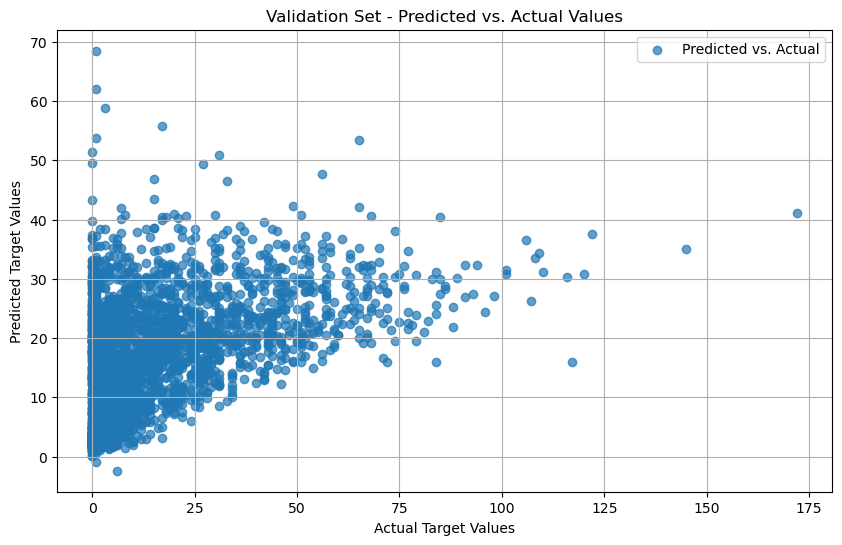

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 19.23


### Deep NN

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_processed_scaled = scaler.fit_transform(X_processed)
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Define the model architecture
model = keras.Sequential([
  layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(256, activation='relu'),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(128, activation='relu'),  # Second hidden layer with 128 neurons and ReLU activation
  layers.Dense(64, activation='relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(32, activation='relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(1)  # Output layer with 1 neuron for regression (single value prediction)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')  # Mean squared error loss and Adam optimizer



# Train the model with validation split
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)  # Added validation data

# Access training and validation loss history for further analysis (optional)
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/100
300/300 [==============================] - 5s 13ms/step - loss: 525.7346 - val_loss: 812.1312
Epoch 2/100
300/300 [==============================] - 4s 12ms/step - loss: 367.6661 - val_loss: 347.5015
Epoch 3/100
300/300 [==============================] - 3s 11ms/step - loss: 347.5027 - val_loss: 342.1517
Epoch 4/100
300/300 [==============================] - 3s 11ms/step - loss: 333.9038 - val_loss: 355.2978
Epoch 5/100
300/300 [==============================] - 3s 11ms/step - loss: 329.5605 - val_loss: 331.0279
Epoch 6/100
300/300 [==============================] - 3s 11ms/step - loss: 332.9339 - val_loss: 338.1597
Epoch 7/100
300/300 [==============================] - 3s 12ms/step - loss: 327.6294 - val_loss: 329.6011
Epoch 8/100
300/300 [==============================] - 3s 11ms/step - loss: 322.7045 - val_loss: 341.2361
Epoch 9/100
300/300 [==============================] - 3s 11ms/step - loss: 331.1420 - val_loss: 332.1675
Epoch 10/100
300/300 [========================


KeyboardInterrupt

